In [1]:
import numpy as np 
from os.path import join
from glob import glob
import xarray as xr 
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2

### Project Ideas 

Goal of this project to provide a super resolution of the 3 km. Since we are learning from 1-km data, we might also be able to learn biases between 3 km and 1 km. Since the data is based on a single channel. 

1. Upscale the 1-km reflectivity forecasts to 3-km and train DL model to predict the 1-km forecasts
    * Explore different upscaling techniques (maximum value or spatial averaging). We want to make sure the upscaling is representative of an original coarsen grid. 
    * Explore influence of patch size 
    * Compare CNN vs. U-net. 
2. Apply the DL model to original 3 km forecasts. Randy suggested evaluating on very short term forecasts such that the 1-km forecast is still a reasonable truth. 
3. Possibly also do classification? 

In [27]:
n = 5 
n%2

1

### Data Size 
1. Different ensemble members will act as different inputs 
2. We have output every 5 min 
3. Based on Randy's advice, create a dataset that can be loaded into memory is more advantageous. 

In [2]:
"""Helper methods for Fourier transforms in 2-D space."""

import numpy
TOLERANCE = 1e-6


def taper_spatial_data(spatial_data_matrix):
    """Tapers spatial data by putting zeros along the edge.
    M = number of rows in grid
    N = number of columns in grid
    :param spatial_data_matrix: M-by-N numpy array of real numbers.
    :return: spatial_data_matrix: Same but after tapering.
    """
    num_rows = spatial_data_matrix.shape[0]
    num_columns = spatial_data_matrix.shape[1]
    
    # If the number is even, make it odd
    row_pad = 1 if num_rows%2 == 0 else 0
    col_pad = 1 if num_columns%2 == 0 else 0

    padding_arg = (
        (row_pad, 0),
        (col_pad, 0)
    )

    spatial_data_matrix = numpy.pad(
        spatial_data_matrix, pad_width=padding_arg, mode='constant',
        constant_values=0.
    )

    return spatial_data_matrix


def _get_spatial_resolutions(num_grid_rows, num_grid_columns,
                             grid_spacing_metres):
    """Computes spatial resolution for each Fourier coefficient.
    M = number of rows in spatial grid
    N = number of columns in spatial grid
    Matrices returned by this method correspond to matrices of Fourier
    coefficients returned by `numpy.fft.fft2`.  The x-coordinate increases with
    column index, and the y-coordinate increases with row index.
    :param num_grid_rows: M in the above discussion.
    :param num_grid_columns: N in the above discussion.
    :param grid_spacing_metres: Grid spacing (for which I use "resolution" as a
        synonym).
    :return: x_resolution_matrix_metres: M-by-N numpy array of resolutions in
        x-direction.
    :return: y_resolution_matrix_metres: Same but for y-direction.
    """

    num_half_rows_float = float(num_grid_rows - 1) / 2
    num_half_rows = int(numpy.round(num_half_rows_float))

    num_half_columns_float = float(num_grid_columns - 1) / 2
    num_half_columns = int(numpy.round(num_half_columns_float))

    # Find resolutions in x-direction.
    unique_x_wavenumbers = numpy.linspace(
        0, num_half_columns, num=num_half_columns + 1, dtype=int
    )
    x_wavenumbers = numpy.concatenate((
        unique_x_wavenumbers, unique_x_wavenumbers[1:][::-1]
    ))
    x_wavenumber_matrix = numpy.expand_dims(x_wavenumbers, axis=0)
    x_wavenumber_matrix = numpy.repeat(
        x_wavenumber_matrix, axis=0, repeats=num_grid_rows
    )

    #x_wavenumber_matrix[x_wavenumber_matrix==0] = 1e-6
    
    x_grid_length_metres = grid_spacing_metres * (num_grid_columns - 1)
    x_resolution_matrix_metres = (
        0.5 * x_grid_length_metres / x_wavenumber_matrix
    )

    # Find resolutions in y-direction.
    unique_y_wavenumbers = numpy.linspace(
        0, num_half_rows, num=num_half_rows + 1, dtype=int
    )
    y_wavenumbers = numpy.concatenate((
        unique_y_wavenumbers, unique_y_wavenumbers[1:][::-1]
    ))
    y_wavenumber_matrix = numpy.expand_dims(y_wavenumbers, axis=1)
    y_wavenumber_matrix = numpy.repeat(
        y_wavenumber_matrix, axis=1, repeats=num_grid_columns
    )
    
    #y_wavenumber_matrix[y_wavenumber_matrix<1e-7] = 1e-6

    y_grid_length_metres = grid_spacing_metres * (num_grid_rows - 1)
    y_resolution_matrix_metres = (
        0.5 * y_grid_length_metres / y_wavenumber_matrix
    )

    return x_resolution_matrix_metres, y_resolution_matrix_metres


def apply_rectangular_filter(
        coefficient_matrix, grid_spacing_metres, min_resolution_metres,
        max_resolution_metres):
    """Applies rectangular band-pass filter to Fourier coefficients.
    M = number of rows in spatial grid
    N = number of columns in spatial grid
    :param coefficient_matrix: M-by-N numpy array of coefficients in format
        returned by `numpy.fft.fft2`.
    :param grid_spacing_metres: Grid spacing (resolution).
    :param min_resolution_metres: Minimum resolution to preserve.
    :param max_resolution_metres: Max resolution to preserve.
    :return: coefficient_matrix: Same as input but maybe with some coefficients
        zeroed out.
    """

    # Do actual stuff.
    x_resolution_matrix_metres, y_resolution_matrix_metres = (
        _get_spatial_resolutions(
            num_grid_rows=coefficient_matrix.shape[0],
            num_grid_columns=coefficient_matrix.shape[1],
            grid_spacing_metres=grid_spacing_metres
        )
    )

    resolution_matrix_metres = numpy.sqrt(
        x_resolution_matrix_metres ** 2 + y_resolution_matrix_metres ** 2
    )

    coefficient_matrix[resolution_matrix_metres > max_resolution_metres] = 0.
    coefficient_matrix[resolution_matrix_metres < min_resolution_metres] = 0.
    return coefficient_matrix


def apply_butterworth_filter(
        coefficient_matrix, filter_order, grid_spacing_metres,
        min_resolution_metres, max_resolution_metres):
    """Applies Butterworth band-pass filter to Fourier coefficients.
    :param coefficient_matrix: See doc for `apply_rectangular_filter`.
    :param filter_order: Order of Butterworth filter (same as input arg `N` for
        `scipy.signal.butter`).
    :param grid_spacing_metres: See doc for `apply_rectangular_filter`.
    :param min_resolution_metres: Same.
    :param max_resolution_metres: Same.
    :return: coefficient_matrix: Same as input but after filtering.
    """

    # Determine horizontal, vertical, and total wavenumber for each Fourier
    # coefficient.
    x_resolution_matrix_metres, y_resolution_matrix_metres = (
        _get_spatial_resolutions(
            num_grid_rows=coefficient_matrix.shape[0],
            num_grid_columns=coefficient_matrix.shape[1],
            grid_spacing_metres=grid_spacing_metres
        )
    )

    x_wavenumber_matrix_metres01 = (2 * x_resolution_matrix_metres) ** -1
    y_wavenumber_matrix_metres01 = (2 * y_resolution_matrix_metres) ** -1
    wavenumber_matrix_metres01 = numpy.sqrt(
        x_wavenumber_matrix_metres01 ** 2 + y_wavenumber_matrix_metres01 ** 2
    )

    # High-pass part.
    if not numpy.isinf(max_resolution_metres):
        min_wavenumber_metres01 = (2 * max_resolution_metres) ** -1
        ratio_matrix = wavenumber_matrix_metres01 / min_wavenumber_metres01
        gain_matrix = 1 - (1 + ratio_matrix ** (2 * filter_order)) ** -1
        coefficient_matrix = coefficient_matrix * gain_matrix

    # Low-pass part.
    if min_resolution_metres > grid_spacing_metres:
        max_wavenumber_metres01 = (2 * min_resolution_metres) ** -1
        ratio_matrix = wavenumber_matrix_metres01 / max_wavenumber_metres01
        gain_matrix = (1 + ratio_matrix ** (2 * filter_order)) ** -1
        coefficient_matrix = coefficient_matrix * gain_matrix

    return coefficient_matrix

### How to patch the data? 

### How to properly re-sample between 1 and 3 km 

In [3]:
#/work/brian.matilla/WOFS_2021/summary_files/WOFS_JET/WOFS_1km_downscaled/

base_path = '/work/brian.matilla/WOFS_2021/summary_files/WOFS_JET/WOFS_1KM/'
date = '20210518'
init_time = '0000'
file_path = glob(join(base_path, date, init_time, 'wofs_ENS_10*'))[0]

In [4]:
ds = xr.load_dataset(file_path, decode_times=False)

In [5]:
# okubo_weiss, uh_0to2
data = ds['comp_dz'].values[0, :,:]

In [6]:
# Filtering out data lower than 3 km
# Pad the data for the prior to filtering
data_pad = taper_spatial_data(data)

# Fourier transform the data
coefficient_matrix = fft2(data_pad)

grid_spacing_metres = 1000
min_resolution_metres = 3000
max_resolution_metres = np.inf
filter_order=6

# Apply the filtering in the transformed space
new_coef_mat = apply_butterworth_filter(
        coefficient_matrix, filter_order, grid_spacing_metres,
        min_resolution_metres, max_resolution_metres)

# Convert back to the original space. 
data_filtered = ifft2(coefficient_matrix)

# Remove the complex components. 
data_filtered = np.real(data_filtered)

/tmp/ipykernel_567600/3515400037.py:73: RuntimeWarning: divide by zero encountered in divide
  0.5 * x_grid_length_metres / x_wavenumber_matrix
/tmp/ipykernel_567600/3515400037.py:92: RuntimeWarning: divide by zero encountered in divide
  0.5 * y_grid_length_metres / y_wavenumber_matrix


In [5]:
import numba as nb
def limit_domain_area(data, delta):
    """Set the surrounding area of the domain to zero"""
    new_data = np.zeros(data.shape)
    new_data[delta:-delta, delta:-delta] = data[delta:-delta, delta:-delta]

    return new_data


@nb.jit(nopython=True, parallel=True)
def extract_patch(data, centers, delta=10):
    """Extract patches 
    
    data : shape of (v,y,x)
    centers  
    """
    # Ensure the centers do not conflict the boundaries. 
    centers = nb.typed.List(centers)
    
    patches = [ ]
    for obj_y, obj_x in centers:
        ##print(obj_y, obj_x)
        patches.append( data[:, obj_y-delta:obj_y+delta+1, obj_x-delta:obj_x+delta+1] )

    return patches

In [6]:
%%time
# Set the perimeter to zero so that the chosen centers do not overtake the domain boundaries 
new_data = limit_domain_area(data, delta=10)
# Center patches on vorticity > 0.01 /s
j,i = np.where(new_data > 30)
# Convert the centers to a numba-friendly format
centers = nb.typed.List(list(zip(j,i)))
patches = np.array(extract_patch(np.array([data]), centers))

CPU times: user 518 ms, sys: 20.1 ms, total: 539 ms
Wall time: 563 ms


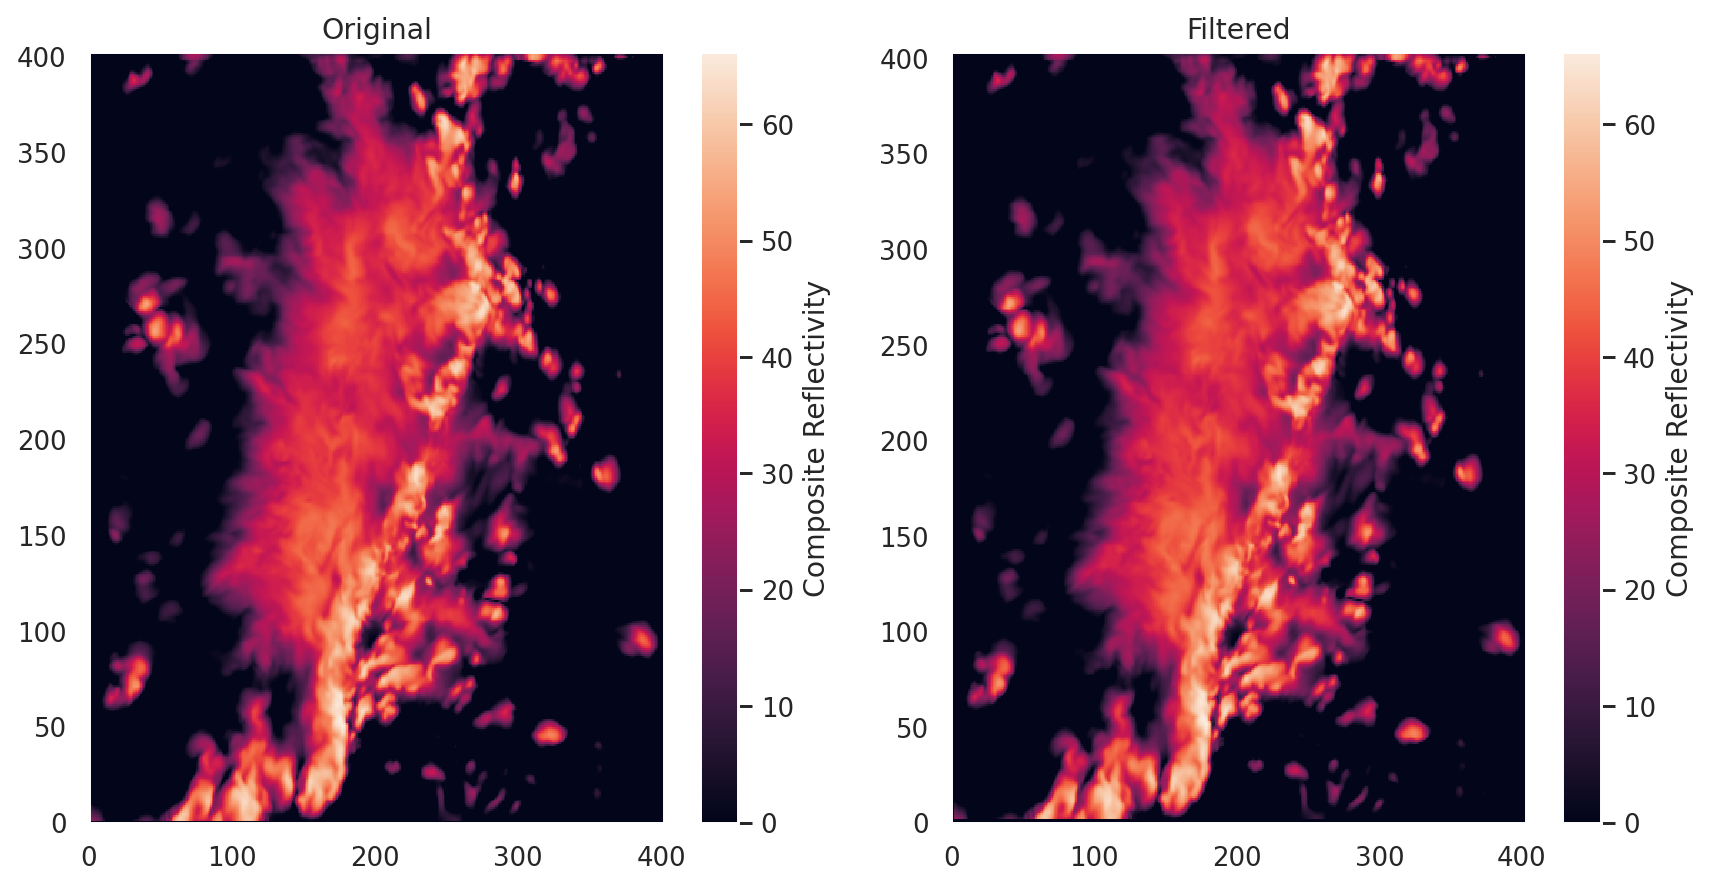

In [7]:
import seaborn as sns
sns.set_theme()
fig,axes = plt.subplots(dpi=170, ncols=2, figsize=(12,6))

for ax, img, title in zip(axes.flat, [data, data_filtered], ['Original', 'Filtered']):
    im = ax.pcolormesh(img)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, label='Composite Reflectivity')
    ax.grid(False)

Text(0.5, 1.0, 'Image Patch')

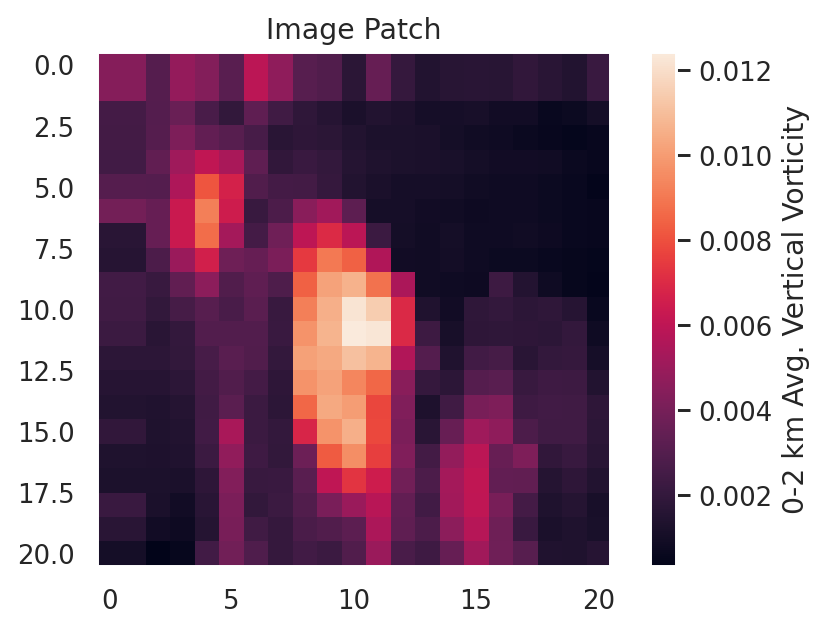

In [8]:
fig,ax = plt.subplots(dpi=170)
im = ax.imshow(patches[0,0,:,:])
fig.colorbar(im, label='Composite Reflectivity')
ax.grid(False)
ax.set_title('Image Patch')